In [1]:
import numpy as np
from matplotlib import pyplot as plt
from photutils import EllipticalAnnulus
import marvin
from marvin.tools.maps import Maps
from marvin.tools.cube import Cube

INFO: No release version set. Setting default to MPL-6


# Aperture photmetry example

In [2]:
maps = Maps(plateifu='7443-12701')

nsa_elpetro_ba = maps.nsa['elpetro_ba']
nsa_elpetro_phi = maps.nsa['elpetro_phi']

In [3]:
#Get the map dimensions
haflux = maps.getMap('emline_gflux', channel='ha_6564')

x = haflux.shape[0]/2
y = haflux.shape[1]/2

#Set inner and outer major and minor axis ratio
ellip_ap_radius_pix_in_major = 5.
ellip_ap_radius_pix_out_major = 15.
ellip_ap_radius_pix_out_minor = nsa_elpetro_ba * ellip_ap_radius_pix_out_major

#The rotation angle in radians of the semimajor axis from the
#positive x axis. The rotation angle increases counterclockwise.
#nsa_elpetro_phi is Angle (E of N) - needs -90 to make the right way up.
theta = np.radians(nsa_elpetro_phi-90.)

In [4]:
#Function to return an elliptical aperture mask
def getAperture(x, y, ellip_ap_radius_pix_in_major, ellip_ap_radius_pix_out_major, ellip_ap_radius_pix_out_minor, \
                theta):

    ellipical_annuli = EllipticalAnnulus([x,y], ellip_ap_radius_pix_in_major, ellip_ap_radius_pix_out_major, \
                                         ellip_ap_radius_pix_out_minor, theta) #In pixels
    masks_ellipical = ellipical_annuli.to_mask(method='exact')
    mask_ellipical = masks_ellipical[0] #Because masks is a list (even if it has one element)
            
    return mask_ellipical


In [5]:
mask_ellipical = getAperture(x, y, ellip_ap_radius_pix_in_major, ellip_ap_radius_pix_out_major, \
                             ellip_ap_radius_pix_out_minor, theta)

In [6]:
#Apply mask to a map
ha_cutout = mask_ellipical.cutout(haflux.value)

In [7]:
#Sum map
print np.sum(ha_cutout)

39.27380312900001


In [8]:
cc = maps.getCube()
waverest = cc.flux.wavelength/(1.+cc.nsa['z'])
flux = cc.flux

# Example of stacking

In [9]:
#Get mask in the right shape to apply to flux cube.
tmp = np.zeros((flux.shape[1], flux.shape[2]))
tmp[mask_ellipical.bbox.slices[0].start:mask_ellipical.bbox.slices[0].stop, \
     mask_ellipical.bbox.slices[1].start:mask_ellipical.bbox.slices[1].stop] = mask_ellipical.data
totmask = tmp.reshape((-1, flux.shape[1], flux.shape[2]))

#Apply mask
masked_fluxrest = totmask * flux

#Stack MaNGA spectra
flux_reshaped = np.reshape(masked_fluxrest, (len(waverest), -1))
flux_stack = np.sum(flux_reshaped, axis=1)

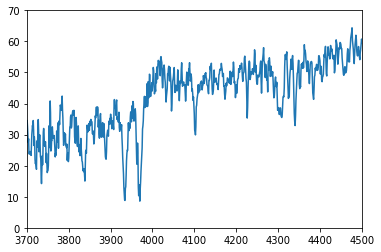

In [10]:
plt.plot(waverest, flux_stack.value)
plt.xlim(3700.,4500)
plt.ylim(0, 70)
plt.show()